# Drzewa decyzyjne — klasyfikacja i regresja

W tym laboratorium zbudujemy drzewa decyzyjne do:
- klasyfikacji (zbiór Breast Cancer z sklearn), optymalizując głębokość drzewa pod F1-score,
- regresji (dane syntetyczne), optymalizując głębokość pod MSE,
- porównamy regresor drzewa z KNN i regresją wielomianową.

## Krótka teoria
Drzewo decyzyjne rekursywnie dzieli przestrzeń cech regułami typu „jeśli–to”, wybierając podziały maksymalizujące jednorodność w węzłach (np. wg Gini lub entropii w klasyfikacji; w regresji minimalizuje się błąd węzłów, np. MSE/MAE).

- Zalety: interpretowalność, brak potrzeby skalowania/normalizacji, obsługa cech nieliniowych i interakcji.
- Wady: skłonność do przeuczenia (overfitting) — szczególnie przy dużej głębokości. Dlatego kontrolujemy złożoność parametrami jak max_depth, min_samples_leaf itd. albo stosujemy pruning.
- Dobór hiperparametrów: używamy walidacji krzyżowej (GridSearchCV) z metryką dopasowaną do zadania:
  - F1 w klasyfikacji (balans precyzji i czułości),
  - MSE w regresji (średni błąd kwadratowy).

Wyniki zapisujemy do plików .pkl (praktyczne pod sprawdzarkę/raporty).


## Przygotowanie danych

- Wczytujemy Breast Cancer i wybieramy 2 cechy do wizualizacji.
- Generujemy syntetyczne dane do regresji (wielomian 4. stopnia + szum).


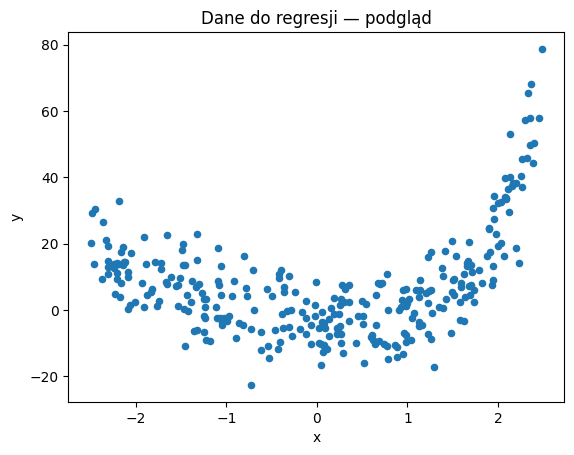

In [1]:

from sklearn import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Breast Cancer
data_breast_cancer = datasets.load_breast_cancer(as_frame=True)
df_breast_cancer = data_breast_cancer['data'][['mean texture', 'mean symmetry']].copy()
df_breast_cancer['target'] = data_breast_cancer['target']

# Dane syntetyczne do regresji
size = 300
X = np.random.rand(size) * 5 - 2.5
w4, w3, w2, w1, w0 = 1, 2, 1, -4, 2
y = w4*(X**4) + w3*(X**3) + w2*(X**2) + w1*X + w0 + np.random.randn(size)*8 - 4
df = pd.DataFrame({'x': X, 'y': y})

# Podgląd danych
df.plot.scatter(x='x', y='y')
plt.title("Dane do regresji — podgląd")
plt.show()


## Klasyfikacja (Breast Cancer) — strojenie max_depth po F1-score

Szukamy najlepszej głębokości drzewa za pomocą GridSearchCV (walidacja krzyżowa, metryka F1).


Najlepsza głębokość: 2
Najlepsze uśrednione F1 (CV): 0.8080236039186941
F1 train: 0.826530612244898 | F1 test: 0.7659574468085106
ACC train: 0.7758241758241758 | ACC test: 0.7105263157894737


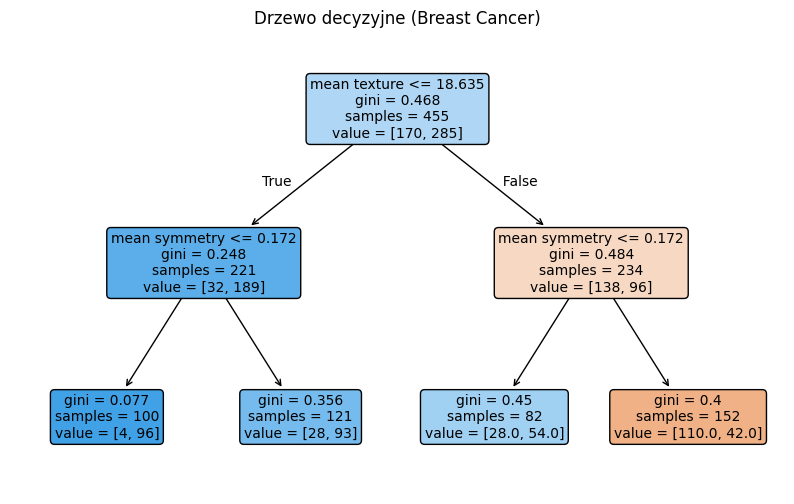

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import f1_score, accuracy_score

# Podział danych
X_train, X_test, y_train, y_test = train_test_split(
    df_breast_cancer[['mean texture', 'mean symmetry']],
    df_breast_cancer['target'],
    test_size=0.2,
    random_state=42,
    stratify=df_breast_cancer['target']
)

# Siatka głębokości
param_grid = {'max_depth': range(1, 11)}
tree = DecisionTreeClassifier(random_state=42)

search = GridSearchCV(tree, param_grid=param_grid, scoring="f1", n_jobs=-1, cv=3)
search.fit(X_train, y_train)

best_max_depth = search.best_params_['max_depth']
print(f"Najlepsza głębokość: {best_max_depth}")
print(f"Najlepsze uśrednione F1 (CV): {search.best_score_}")

# Ocena na train/test
y_pred_train = search.predict(X_train)
y_pred_test  = search.predict(X_test)

f1_train = f1_score(y_train, y_pred_train)
f1_test  = f1_score(y_test,  y_pred_test)
acc_train = accuracy_score(y_train, y_pred_train)
acc_test  = accuracy_score(y_test,  y_pred_test)

print("F1 train:", f1_train, "| F1 test:", f1_test)
print("ACC train:", acc_train, "| ACC test:", acc_test)

# Rysunek drzewa
plt.figure(figsize=(10, 6))
plot_tree(search.best_estimator_, filled=True, rounded=True, feature_names=['mean texture', 'mean symmetry'])
plt.title("Drzewo decyzyjne (Breast Cancer)")
plt.show()

# Pominięto eksport drzewa do pliku PNG
# Pominięto zapis wyników do pliku .pkl

## Regresja (syntetyczne) — strojenie max_depth po MSE

Używamy DecisionTreeRegressor i GridSearchCV (metryka neg_mean_squared_error, im większa tym lepiej — zapisujemy MSE dodatnie).


Najlepsza głębokość: 3
Najlepsze uśrednione MSE (CV): 76.45559184210771
MSE train: 58.67124793883482
MSE test:  73.45366572388726


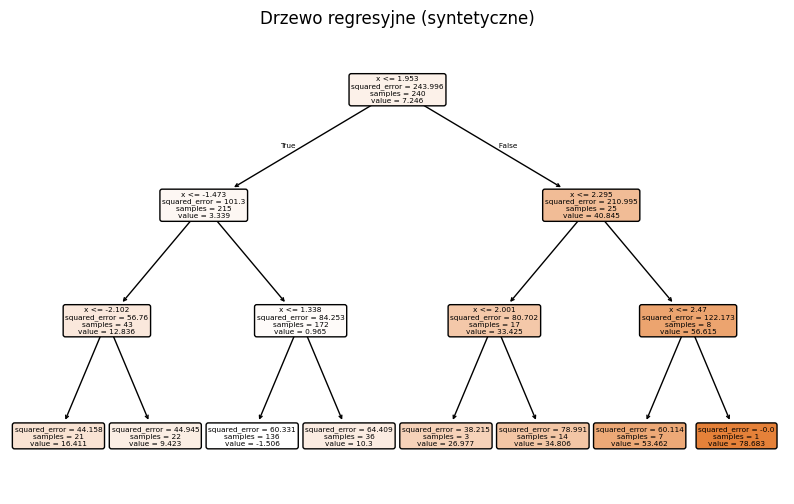

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error

# Podział danych
X_train, X_test, y_train, y_test = train_test_split(df[['x']], df[['y']], test_size=0.2, random_state=42)

param_grid = {'max_depth': range(1, 11)}
tree_reg = DecisionTreeRegressor(random_state=42)

search = GridSearchCV(tree_reg, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=3)
search.fit(X_train, y_train)

best_max_depth = search.best_params_['max_depth']
best_mse_cv = -search.best_score_
print(f"Najlepsza głębokość: {best_max_depth}")
print(f"Najlepsze uśrednione MSE (CV): {best_mse_cv}")

mse_train = mean_squared_error(y_train, search.predict(X_train))
mse_test  = mean_squared_error(y_test,  search.predict(X_test))
print(f"MSE train: {mse_train}")
print(f"MSE test:  {mse_test}")

# Rysunek drzewa
plt.figure(figsize=(10, 6))
plot_tree(search.best_estimator_, filled=True, rounded=True, feature_names=['x'])
plt.title("Drzewo regresyjne (syntetyczne)")
plt.show()

# Pominięto zapis wyników do pliku .pkl

## Porównanie różnych regressorów (KNN, regresja wielomianowa, drzewo)

Rysujemy trzy osobne wykresy (każdy osobno — bez subplots): predykcje modeli vs. dane.


/media/mikolaj/Nowy/Desktop/isi4/Machine-Learning-Studies/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/media/mikolaj/Nowy/Desktop/isi4/Machine-Learning-Studies/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/media/mikolaj/Nowy/Desktop/isi4/Machine-Learning-Studies/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


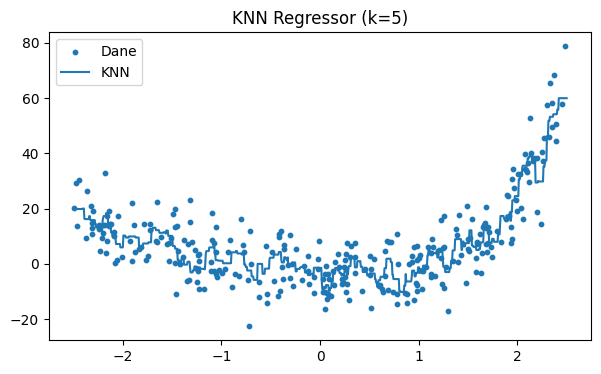

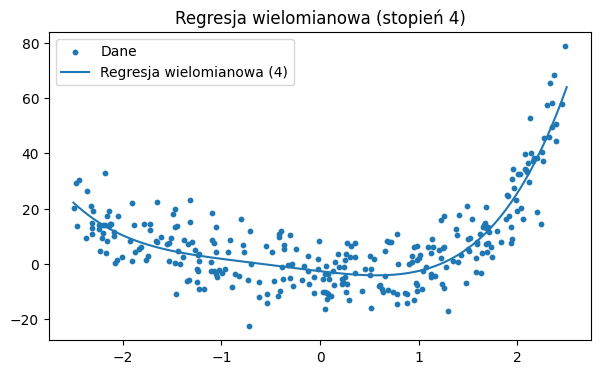

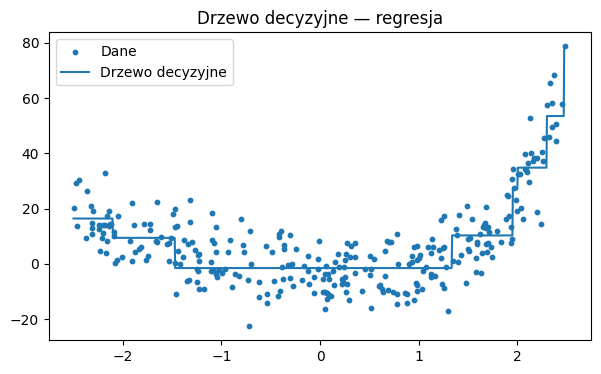

In [4]:

from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
import numpy as np

# Trenowanie modeli na tych samych danych treningowych co drzewo
poly_feature_4 = PolynomialFeatures(degree=4, include_bias=False)
X_poly_4 = poly_feature_4.fit_transform(X_train)
poly_4_reg = LinearRegression()
poly_4_reg.fit(X_poly_4, y_train)

knn_5_reg = KNeighborsRegressor(n_neighbors=5)
knn_5_reg.fit(X_train, y_train)

X_range = np.linspace(-2.5, 2.5, 1000).reshape(-1, 1)
y_knn  = knn_5_reg.predict(X_range)
y_poly = poly_4_reg.predict(poly_feature_4.transform(X_range))
y_tree = search.predict(X_range)

# Wykresy (oddzielne figury — zgodnie z wytycznymi)
plt.figure(figsize=(7, 4))
plt.scatter(X, y, s=10, label='Dane')
plt.plot(X_range, y_knn, label='KNN')
plt.title('KNN Regressor (k=5)')
plt.legend()
plt.show()

plt.figure(figsize=(7, 4))
plt.scatter(X, y, s=10, label='Dane')
plt.plot(X_range, y_poly, label='Regresja wielomianowa (4)')
plt.title('Regresja wielomianowa (stopień 4)')
plt.legend()
plt.show()

plt.figure(figsize=(7, 4))
plt.scatter(X, y, s=10, label='Dane')
plt.plot(X_range, y_tree, label='Drzewo decyzyjne')
plt.title('Drzewo decyzyjne — regresja')
plt.legend()
plt.show()


## Podsumowanie

W tym laboratorium przeanalizowano drzewa decyzyjne w zadaniach klasyfikacji i regresji. Pokazano, jak dobór parametrów drzewa wpływa na jakość predykcji oraz porównano wyniki z innymi regressorami (KNN, regresja wielomianowa). Drzewa decyzyjne są intuicyjne i elastyczne, ale wymagają kontroli złożoności, by uniknąć przeuczenia.